In [34]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 

In [35]:
rho0 = 1
alpha = 0.01
beta = 0.01

T1a = 5
T2a = 25

eta = 0.005

tau_atm = 1
tau_cir = 1000

In [36]:
def f_eta(t):
    # return 0.0015 * np.cos(t/2e4)**2
    # return 0.0015 * np.exp(- ((t - 1e5)/5e4) ** 2)
    return 0.0015 * np.sin(t / 1.5e5) ** 24 + 0.0000002

In [37]:
def rho(T, S):
    return rho0 - alpha * T + beta * S

def dYdt(t, Y):

    T1, T2, S1, S2 = Y

    dT = T2 - T2
    dS = S2 - S1

    psi = (rho(T1, S1) - rho(T2, S2)) / (rho0 * tau_cir)

    dT1dt = np.abs(psi) * dT + (T1a - T1) / tau_atm
    dT2dt = - np.abs(psi) * dT + (T2a - T2) / tau_atm

    dS1dt = np.abs(psi) * dS - f_eta(t)
    dS2dt = - np.abs(psi) * dS + f_eta(t)

    return np.array([dT1dt, dT2dt, dS1dt, dS2dt])

In [38]:
Y0 = (15, 15, 10, 10)
sol = solve_ivp(dYdt, (0, 1e6), Y0)
T1, T2, S1, S2 = sol.y
t = sol.t

psi = (rho(T1, S1) - rho(T2, S2)) / (rho0 * tau_cir)

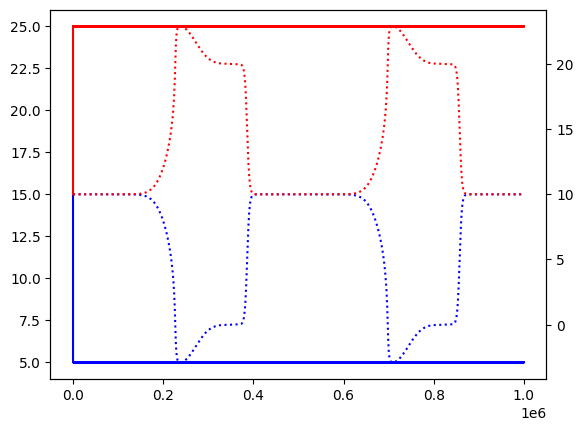

In [39]:
fig, ax = plt.subplots()

ax.plot(t, T1, 'b-')
ax.plot(t, T2, 'r-')
ax2 = ax.twinx()
ax2.plot(t, S1, 'b:')
ax2.plot(t, S2, 'r:')

plt.show()

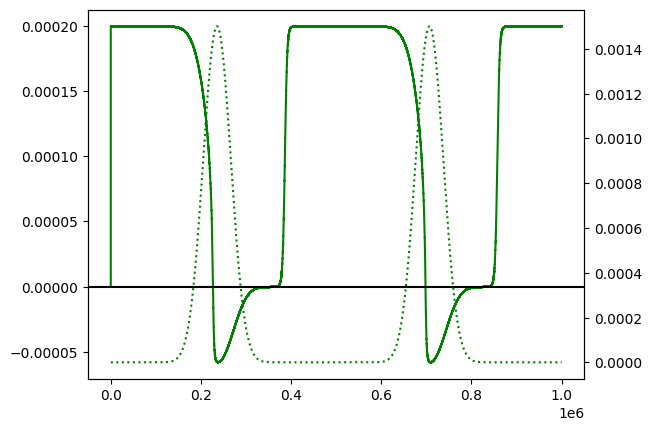

In [40]:
fig, ax = plt.subplots()

ax.plot(t, psi, 'g-')
ax.axhline(0, color='black')

ax2 = ax.twinx()

ax2.plot(t, f_eta(t), 'g:')

plt.show()

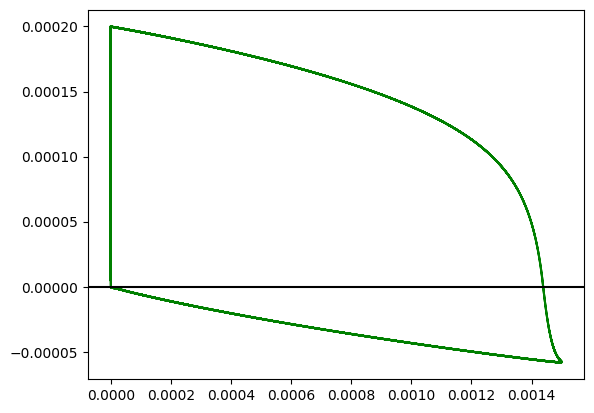

In [41]:
plt.plot(f_eta(t[2:]), psi[2:], 'g-')
plt.axhline(0, color='black')
# plt.xlim([0, 0.002])
plt.show()

In [42]:
def H(x, k=1e7):
    return 0.5 *((k*x) / (np.sqrt(1 + (k * x) ** 2)) + 1)

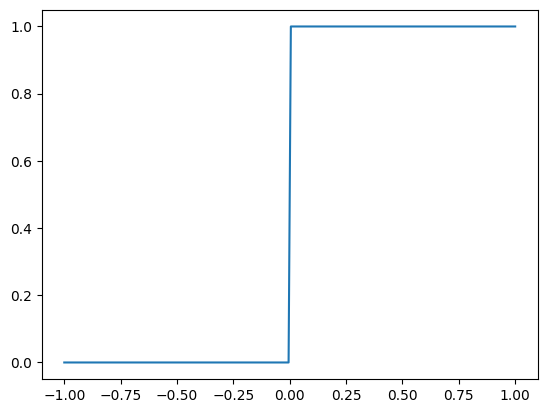

In [43]:
plt.plot(np.linspace(-1, 1, num=200), H(np.linspace(-1, 1, num=200)))

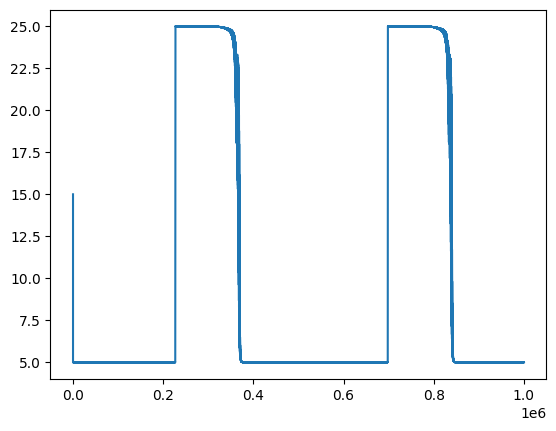

In [44]:
T_floor = H(psi) * T1 + H(-psi) * T2
plt.plot(t, T_floor)